In [3]:
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import mannwhitneyu
import math
import numpy as np
from scipy.spatial.distance import jaccard
# from scipy.spatial.distance import pdist
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from tqdm.auto import tqdm

This project received funding from the European Union’s Horizon 2020 research and innovation programme [952914] (FindingPheno).

## Loading the available data:

First a table that maps SNPS ("marker") to genes ("GeneSymbol")

In [4]:
themap = pd.read_csv("../../data/salmon_data/HoloFish_HostG_SNP_annotation_GENES.txt")

In [5]:
themap.head()

,marker,GeneSymbol,Class
0,NC_059442.1_219649,LOC123726714,protein_coding
1,NC_059442.1_422675,wdr32,protein_coding
2,NC_059442.1_423636,wdr32,protein_coding
3,NC_059442.1_424097,wdr32,protein_coding
4,NC_059442.1_424181,wdr32,protein_coding


Next, we have a table that carries the metadata of the samples:

In [6]:
metadata = pd.read_csv("../../data/salmon_data/HoloFish_FishVariables_20221116.csv")
metadata.head()

,Sample.ID,Size.class,Gutted.Weight.kg,Tapeworm.index,Tapeworm.present,Feed.Type,Metabolome.batch,HostG.Ind.ID,Dataset.MetaG,Dataset.HostRNA,Dataset.Metabolome,Dataset.HostG
0,F001,Medium,3.24,1,True,Feed1,Batch_1,Ind0,False,True,True,True
1,F010,Small,1.77,1,True,Feed1,Batch_1,Ind8,True,True,True,True
2,F100,Medium,3.15,1,True,Feed1,NaN,NaN,False,False,False,False
3,F101,Medium,3.21,1,True,Feed1,Batch_3,Ind87,True,True,True,True
4,F102,Medium,3.34,1,True,Feed1,Batch_3,Ind88,True,True,True,True


A table that maps genes to their associated GO terms. Notice that many genes (symbol) are not associated to any GO term

In [7]:
go = pd.read_csv("../../data/salmon_data/salmon_GO_annotations.tsv", sep="\t")

In [8]:
go.head()

,SYMBOL,ENTREZID,GENENAME,GO,ONTOLOGY,GO.term
0,1433b,100196586.0,14-3-3 protein beta/alpha,NaN,NaN,NaN
1,143b2,100195171.0,14-3-3 protein beta/alpha-2,GO:0004497,MF,"Term = \monooxygenase activity\"""""
2,143g1,100380373.0,14-3-3 protein gamma-1,NaN,NaN,NaN
3,143g2,100194987.0,14-3-3 protein gamma-2,NaN,NaN,NaN
4,2a5e,100195340.0,Serine/threonine-protein phosphatase 2A 56 kDa...,GO:0000159,CC,"Term = \protein phosphatase type 2A complex\"""""


So we'll drop the genes with no association:

In [9]:
go = go.dropna()
go.head()

,SYMBOL,ENTREZID,GENENAME,GO,ONTOLOGY,GO.term
1,143b2,100195171.0,14-3-3 protein beta/alpha-2,GO:0004497,MF,"Term = \monooxygenase activity\"""""
4,2a5e,100195340.0,Serine/threonine-protein phosphatase 2A 56 kDa...,GO:0000159,CC,"Term = \protein phosphatase type 2A complex\"""""
5,2a5e,100195340.0,Serine/threonine-protein phosphatase 2A 56 kDa...,GO:0019888,MF,Term = \protein phosphatase regulator activit...
6,2a5e,100195340.0,Serine/threonine-protein phosphatase 2A 56 kDa...,GO:0007165,BP,"Term = \signal transduction\"""""
7,4f2,100195278.0,4F2 cell-surface antigen heavy chain,GO:0016020,CC,"Term = \membrane\"""""


We want to keep only the SNPs that map to genes for which we have GO terms.
First we'll isolate the "GO-genes":

In [10]:
go_genes = list(go.SYMBOL.unique())

And then, from the "themap" table, we keep only the rows where the gene name is found inside the "go_genes" list:

In [11]:
relevant_mutations = themap[themap.GeneSymbol.isin(go_genes)].copy()
relevant_mutations.head()

,marker,GeneSymbol,Class
235,NC_059442.1_602813,LOC106607815,protein_coding
236,NC_059442.1_602839,LOC106607815,protein_coding
237,NC_059442.1_602862,LOC106607815,protein_coding
238,NC_059442.1_602907,LOC106607815,protein_coding
239,NC_059442.1_602938,LOC106607815,protein_coding


In [12]:
relevant_mutations.shape

(1117765, 3)

There's 1117765 SNPs/markers left in our table at this point

## How many mutations are mapped to each gene?

The 'relevant mutations' table maps markers to genes, so it allows us to easily count markers per gene and plot it as a histogram:

/home/dylan/miniconda3/envs/gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

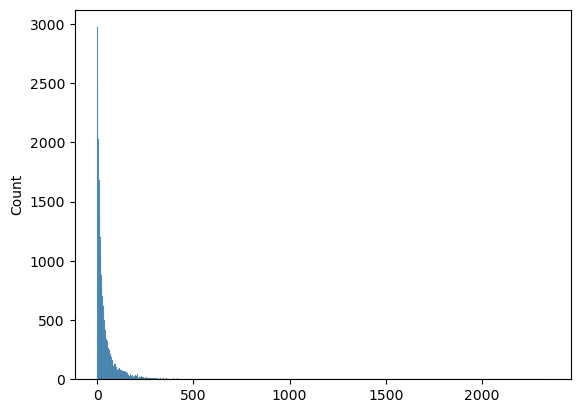

In [13]:
sns.histplot( relevant_mutations.GeneSymbol.value_counts().values )

/home/dylan/miniconda3/envs/gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

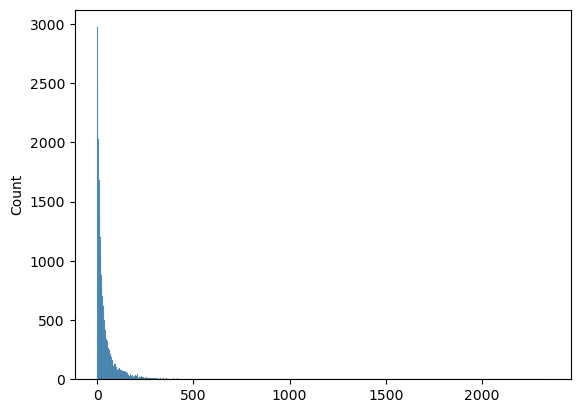

In [14]:
sns.histplot( relevant_mutations.GeneSymbol.value_counts().values )

# plt.xlim((500,3000))

We can see that the vast majority of genes are assigned a small number of SNPs, while very few of them have up to 2000 markers assigned to them.

In [15]:
# 97.5% of genes have less SNPs than:
np.quantile( relevant_mutations.GeneSymbol.value_counts().values, .975)

258.0

## More data loading:

The gwasdf is the big table that keeps the dosage data per sample per SNP:

In [16]:
gwasdf = pd.read_csv("../../data/salmon_data/HoloFish_HostG_GenotypeProbability.dose", sep=" ")

In [17]:
gwasdf.head()

,marker,alleleA,alleleB,Ind0,Ind1,Ind2,Ind3,Ind4,Ind5,Ind6,...,Ind351,Ind352,Ind353,Ind354,Ind355,Ind356,Ind357,Ind358,Ind359,Ind360
0,NC_059442.1_84727,0,2,1.0000,0.0013,0.9780,0.0035,0.0002,0.0005,0.000,...,0.9999,0.1223,0.0013,0.9994,0.0013,0.9996,0.0347,0.0053,0.0035,0.8773
1,NC_059442.1_84730,1,3,1.0000,0.0005,0.9713,0.0020,0.0001,0.0001,0.000,...,0.9995,0.1111,0.0005,0.9985,0.0005,0.9989,0.0289,0.0040,0.0020,0.8659
2,NC_059442.1_132329,0,1,0.0334,0.0647,0.1294,0.1294,0.0086,0.0086,0.017,...,0.0043,0.0334,0.0334,0.9559,0.9886,0.1294,0.0334,0.1294,0.0000,0.0022
3,NC_059442.1_141907,2,3,0.2496,1.0000,1.0000,1.0002,1.0000,0.0419,1.000,...,1.9880,0.0058,1.0000,0.0005,1.0000,1.8395,1.0000,1.0013,0.0001,1.0000
4,NC_059442.1_141912,2,0,0.2462,1.0000,1.0000,1.0009,1.0000,0.0395,1.000,...,1.9871,0.0052,1.0000,0.0004,1.0000,1.8367,1.0000,1.0063,0.0001,1.0000


In [18]:
gwasdf.shape

(3440818, 364)

The gwasdf names the samples as "Ind0","Ind1" etc, but we've been using the "F001" samples IDs from the other tables, 
so we'll need to rename the smaples:

In [19]:
# Load a mapping of IndX --> FXXX names
sidm = pd.read_csv("../../data/salmon_data/HoloFish_FishVariables_20221116.csv")
sidm = sidm[["Sample.ID","HostG.Ind.ID"]]
sampleD = {b:a for a,b in sidm.dropna().values}
# rename the samples in the raw gwasdf
gwasdf.columns = list(gwasdf.columns[:3]) + [sampleD.get(x) for x in gwasdf.columns[3:]]

In [20]:
gwasdf.head()

,marker,alleleA,alleleB,F001,F002,F003,F004,F005,F006,F007,...,F444,F445,F446,F447,F448,F449,F450,F451,F460,F461
0,NC_059442.1_84727,0,2,1.0000,0.0013,0.9780,0.0035,0.0002,0.0005,0.000,...,0.9999,0.1223,0.0013,0.9994,0.0013,0.9996,0.0347,0.0053,0.0035,0.8773
1,NC_059442.1_84730,1,3,1.0000,0.0005,0.9713,0.0020,0.0001,0.0001,0.000,...,0.9995,0.1111,0.0005,0.9985,0.0005,0.9989,0.0289,0.0040,0.0020,0.8659
2,NC_059442.1_132329,0,1,0.0334,0.0647,0.1294,0.1294,0.0086,0.0086,0.017,...,0.0043,0.0334,0.0334,0.9559,0.9886,0.1294,0.0334,0.1294,0.0000,0.0022
3,NC_059442.1_141907,2,3,0.2496,1.0000,1.0000,1.0002,1.0000,0.0419,1.000,...,1.9880,0.0058,1.0000,0.0005,1.0000,1.8395,1.0000,1.0013,0.0001,1.0000
4,NC_059442.1_141912,2,0,0.2462,1.0000,1.0000,1.0009,1.0000,0.0395,1.000,...,1.9871,0.0052,1.0000,0.0004,1.0000,1.8367,1.0000,1.0063,0.0001,1.0000


In [21]:
gwasdf.shape

(3440818, 364)

To further process this table, we'll drop the "alleleA/alleleB" columns and set the "marker" column as index.     
Then we'll only keep the SNPs that we've kept in the "relevant_mutations" table:

In [22]:
gwasi = gwasdf.set_index("marker").drop(["alleleA","alleleB"], axis=1)
gwasi = gwasi.loc[list(set(relevant_mutations.marker.values))]

In [23]:
gwasi.shape

(1114328, 361)

In [24]:
all_as_ints = np.round(gwasi.values).flatten()
from collections import Counter
def calculate_proportions(int_list):
    # Count occurrences of each integer
    count = Counter(int_list)
    
    # Total number of integers in the list
    total = len(int_list)
    
    # Calculate and print proportions
    proportions = {key: value / total for key, value in count.items()}
    return proportions
proportions = calculate_proportions(all_as_ints)

for integer, proportion in proportions.items():
    print(f"Integer: {integer}, Proportion: {proportion:.4f}")

Integer: 1.0, Proportion: 0.3115
Integer: 0.0, Proportion: 0.6487
Integer: 2.0, Proportion: 0.0397


## Code to evaluate results on a random dataset

In [25]:
import random
source_list = [0, 1, 2]
weights = [0.6487, 0.3115, 0.0397]  
n = gwasi.shape[0] * gwasi.shape[1]
random_df = random.choices(source_list, weights=weights, k=n)

In [26]:
random_df_vals = np.array(random_df).reshape((gwasi.shape[0], gwasi.shape[1]))

In [27]:
## Uncomment to proceed with a random dataset
# random_df = pd.DataFrame(data=random_df_vals, columns = gwasi.columns, index=gwasi.index)
# gwasi = random_df 

In [28]:
gwasi.head()

,F001,F002,F003,F004,F005,F006,F007,F008,F010,F011,...,F444,F445,F446,F447,F448,F449,F450,F451,F460,F461
marker,,,,,,,,,,,,,,,,,,,,,
NC_059448.1_29539407,0.9994,1.0000,0.0000,0.0,1.0000,1.0000,1.0000,1.0000,1.0668,0.8867,...,0.0000,1.0000,0.0000,0.9996,0.0,0.0,0.9999,0.0024,1.0,1.0000
NC_059448.1_42461608,0.1325,1.0000,1.0000,1.0,0.9932,0.9817,0.0003,1.0000,1.0000,0.1295,...,1.0000,1.0000,1.0000,1.0000,0.0,1.0,0.0014,1.9994,1.0,1.0000
NC_059443.1_40199784,0.0001,0.0002,2.0000,1.0,0.0001,2.0000,1.0000,0.0001,0.0001,0.0005,...,1.0000,0.0025,0.0003,0.0001,1.0,1.0,0.0002,1.0000,0.0,1.0000
NC_059447.1_62274547,1.0000,1.0000,1.0000,1.0,0.0000,0.0001,0.0001,1.0000,0.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,0.0,1.0,0.0009,0.9957,1.0,1.0000
NC_059465.1_13891325,0.0002,0.9999,0.0226,1.0,0.0000,0.0244,1.9786,0.9997,0.0000,1.0000,...,1.2615,0.0002,1.9997,0.0000,1.0,1.0,1.0000,1.0216,1.0,0.0014


## The dosage values

A value of 0 means that there's probability 1 that the sample has 2 wt alleles.
A value of 1 means there's probability of 1 that the sample has one variant and one wt allele.
A value of 2 means that there's probability of 1 that the sample has 2 variabt alleles.

Thus, any value over 0.5 means that the sample has more than 0.5 probability to have at least one variant allele:

In [29]:
# So we'll make a binary version of our table:
gwasib = (gwasi>0.5).astype(bool)
# And we'll filter out the very few cases of SNPs where ALL samples have the variant allele:
mask = gwasib.sum(axis=1)<361
gwasib_f = gwasib[mask]
gwasi_f = gwasi[mask]

In [30]:
gwasib_f.shape

(1114319, 361)

In [31]:
gwasib.shape

(1114328, 361)

In [32]:
gwasib_f.head()

,F001,F002,F003,F004,F005,F006,F007,F008,F010,F011,...,F444,F445,F446,F447,F448,F449,F450,F451,F460,F461
marker,,,,,,,,,,,,,,,,,,,,,
NC_059448.1_29539407,True,True,False,False,True,True,True,True,True,True,...,False,True,False,True,False,False,True,False,True,True
NC_059448.1_42461608,False,True,True,True,True,True,False,True,True,False,...,True,True,True,True,False,True,False,True,True,True
NC_059443.1_40199784,False,False,True,True,False,True,True,False,False,False,...,True,False,False,False,True,True,False,True,False,True
NC_059447.1_62274547,True,True,True,True,False,False,False,True,False,True,...,True,True,True,True,False,True,False,True,True,True
NC_059465.1_13891325,False,True,False,True,False,False,True,True,False,True,...,True,False,True,False,True,True,True,True,True,False


## The weights table

The final data table we'll need is an array with the weight of every sample:

In [33]:
# gwasi.T.index.values here is all our samples in the order with which they were found in the other data tables
weights = metadata.set_index("Sample.ID").loc[gwasi.T.index.values, ["Gutted.Weight.kg"] ].values.squeeze()
weights = weights.squeeze()

In [34]:
weights

array([3.24 , 4.18 , 5.89 , 4.89 , 3.98 , 2.01 , 4.74 , 4.7  , 1.77 ,
       4.24 , 2.57 , 4.3  , 4.27 , 3.94 , 4.76 , 5.23 , 5.11 , 4.27 ,
       1.57 , 4.28 , 1.47 , 1.48 , 0.995, 2.05 , 3.92 , 1.77 , 4.71 ,
       4.37 , 1.31 , 5.11 , 3.81 , 1.1  , 3.96 , 4.39 , 4.75 , 2.145,
       1.47 , 1.62 , 4.43 , 0.92 , 1.7  , 2.3  , 4.44 , 1.67 , 1.44 ,
       4.   , 1.6  , 1.7  , 1.18 , 2.01 , 2.14 , 4.6  , 1.165, 4.85 ,
       2.115, 4.45 , 3.57 , 1.72 , 3.7  , 0.78 , 1.4  , 1.48 , 1.54 ,
       1.8  , 0.935, 2.9  , 3.57 , 3.69 , 1.41 , 1.86 , 2.57 , 4.04 ,
       4.75 , 2.33 , 2.76 , 3.49 , 3.97 , 1.51 , 4.91 , 3.47 , 3.115,
       3.63 , 2.77 , 2.4  , 4.31 , 2.485, 3.065, 3.21 , 3.34 , 5.22 ,
       3.57 , 3.4  , 3.99 , 1.24 , 3.73 , 2.51 , 2.57 , 3.34 , 4.3  ,
       4.21 , 3.72 , 2.17 , 3.05 , 2.445, 2.25 , 3.56 , 1.17 , 5.55 ,
       4.11 , 4.49 , 2.94 , 4.85 , 2.3  , 3.64 , 3.35 , 5.2  , 4.15 ,
       3.18 , 4.54 , 3.345, 4.04 , 3.215, 3.8  , 2.2  , 0.94 , 5.24 ,
       2.72 , 5.1  ,

## We now have all the data we need.

Let's perform our analysis for a single SNP to understand what it is.     
We ask the question "Are the fish that have at least one variant allele significantly larger or smaller than those that don't" ?

To perform this test, we need to select one SNP, let's take the very first one:

In [35]:
test_snp_index = 0

In [36]:
gwasib_f.iloc[0]

F001     True
F002     True
F003    False
F004    False
F005     True
        ...  
F449    False
F450     True
F451    False
F460     True
F461     True
Name: NC_059448.1_29539407, Length: 361, dtype: bool

So this is marker NC_059454.1_82927125, and we have a true/false value per sample.

And we also have the weights of all the samples:

In [37]:
weights[:3]

array([3.24, 4.18, 5.89])

We can use the True/False values of the marker to mask the weights array like this:

In [38]:
row = gwasib_f.iloc[1]
weights_of_samples_that_have = weights[row]
weights_of_samples_that_dont = weights[~row]

And now we can perform the statistical test on this:

In [39]:
score_greater, p_greater = mannwhitneyu( weights_of_samples_that_have,weights_of_samples_that_dont, alternative="greater" )
score_less, p_less = mannwhitneyu( weights_of_samples_that_have,weights_of_samples_that_dont, alternative="less" )

In [40]:
p_greater,p_less

(0.0003648785808783406, 0.9996366140193832)

In this case, we got a p value of 0.2 that the samples that have the variable allele are significantly larger than those that don't.

Performing this test for all SNPs will be very slow, but it is a very easy to parallelize task:

We will spawn multiple processes (instead of just one which is they typical approach), where each process will perform the statistical test in a subset of SNPs.

In [88]:
# import the multiprocessing library for python:
from multiprocessing import Pool, TimeoutError

# define what each separate process will do
# we will be passing the snp row to each process as an argument
# since those are different.
# but each process will create its own copy of the weights
# since those are always the same
def generator_process_f(snp_row):
    marker,row = snp_row
    # make own copy of this array for each process spawned
    weights = metadata.set_index("Sample.ID").loc[gwasi.T.index.values, ["Gutted.Weight.kg"] ].values.squeeze()
    # make the two tests:
    _,pg = mannwhitneyu( weights[row],weights[~row], alternative="greater" )
    _,pl = mannwhitneyu( weights[row],weights[~row], alternative="less" )
    # return the SNP name,p values and the sum of the row which is how many samples have at least one variant allele
    return marker,pg, pl,row.sum()


class Processor(object):
    """The code to be executed by each individual process"""
    def __init__(self, weights):
        """Initialize the class. We do this so that each process only loads the weights array once:"""
        self.weights = weights

    def __call__(self, snp_row):
        marker,row = snp_row
        # make own copy of this array for each process spawned
        # weights = metadata.set_index("Sample.ID").loc[gwasi.T.index.values, ["Gutted.Weight.kg"] ].values.squeeze()
        # make the two tests:
        _,pg = mannwhitneyu( self.weights[row],self.weights[~row], alternative="greater" )
        _,pl = mannwhitneyu( self.weights[row],self.weights[~row], alternative="less" )
        _,pts = mannwhitneyu( self.weights[row],self.weights[~row], alternative="two-sided" )
        # return the SNP name,p values and the sum of the row which is how many samples have at least one variant allele
        return marker,pg, pl, pts, row.sum()


## One final optimization

We have been keeping our data in pandas tables, but numpy arrays are faster to index.
So we'll move to the numpy version of the tables:

In [89]:
ngwasib_f = gwasib_f.values.astype(bool)
markernames = gwasi_f.index.values

In [90]:
# How many cpus do we have in this machine?
import os
cpu_count = os.cpu_count()

In [91]:
# a list to keep the results:
lot = []
# the progress bar:
how_many_SNPs = gwasib_f.shape[0]
with tqdm(total=how_many_SNPs) as pbar:
    # The multiprocess pool (the pool of parallel processes)
    with Pool(processes=26) as pool:
        # Assign the jobs to the processes:
        # we iterate the rows of gwasib_f
        # and give each row to the pool of 24 processes.
        # The results come back in asynchronous order (we don't care about the order as long as we know which snp is which)
        for result in pool.imap_unordered(Processor(weights), zip(markernames,ngwasib_f)):
            lot.append(result)
            pbar.update(1) # update the progress bar

100%|██████████| 1114319/1114319 [02:00<00:00, 9220.47it/s]


In [92]:
# put the results in a dataframe
mws = pd.DataFrame(lot)
mws.columns = ["Marker", "pval_AltGreater", "pval_AltLess", "pval_two_sided", "var_count"]

In [95]:
bonferroni_threshold = -math.log10( 0.05/len(mws))
bonferroni_threshold

7.3480395313021205

In [96]:
# convert the pvalues to -log10 
mws["pval_AltGreater_log"] = mws.pval_AltGreater.apply(lambda x: -math.log10(x))
mws["pval_AltLess_log"] = mws.pval_AltLess.apply(lambda x: -math.log10(x))
mws["maxscore"] = mws.apply(lambda r: max([r["pval_AltLess_log"], r["pval_AltGreater_log"]]), axis=1 )
mws["logpvalue"] = mws.pval_two_sided.apply(lambda x: -math.log10(x))
mws["significant"] = mws.maxscore>bonferroni_threshold

In [97]:
mws.sort_values("maxscore", ascending=False).head(20)

,Marker,pval_AltGreater,pval_AltLess,pval_two_sided,var_count,pval_AltGreater_log,pval_AltLess_log,maxscore,logpvalue,significant
541755,NC_059470.1_26362271,4.960956e-14,1.0,9.921912e-14,106,13.304435,2.135985e-14,13.304435,13.003405,True
90456,NC_059447.1_70521400,7.269689e-14,1.0,1.453938e-13,93,13.138484,3.129243e-14,13.138484,12.837454,True
31982,NC_059454.1_3425874,9.798417e-14,1.0,1.959683e-13,93,13.008844,4.218933e-14,13.008844,12.707814,True
117926,NC_059456.1_20645360,1.834140e-13,1.0,3.668279e-13,77,12.736568,7.893020e-14,12.736568,12.435538,True
1103254,NC_059446.1_21906284,2.892599e-13,1.0,5.785198e-13,83,12.538712,1.245429e-13,12.538712,12.237682,True
678316,NC_059470.1_26676341,2.985422e-13,1.0,5.970844e-13,105,12.524994,1.285931e-13,12.524994,12.223964,True
721890,NC_059446.1_21740206,3.085807e-13,1.0,6.171613e-13,88,12.510631,1.328843e-13,12.510631,12.209601,True
124875,NC_059470.1_26677142,3.109478e-13,1.0,6.218955e-13,105,12.507313,1.339451e-13,12.507313,12.206283,True
432444,NC_059456.1_20625606,3.975909e-13,1.0,7.951818e-13,81,12.400564,1.711681e-13,12.400564,12.099534,True
153969,NC_059456.1_20625624,3.975909e-13,1.0,7.951818e-13,81,12.400564,1.711681e-13,12.400564,12.099534,True


In [98]:
light_green = (0.0, 0.6, 0.5)
pink = (1, 0.078, 0.576)

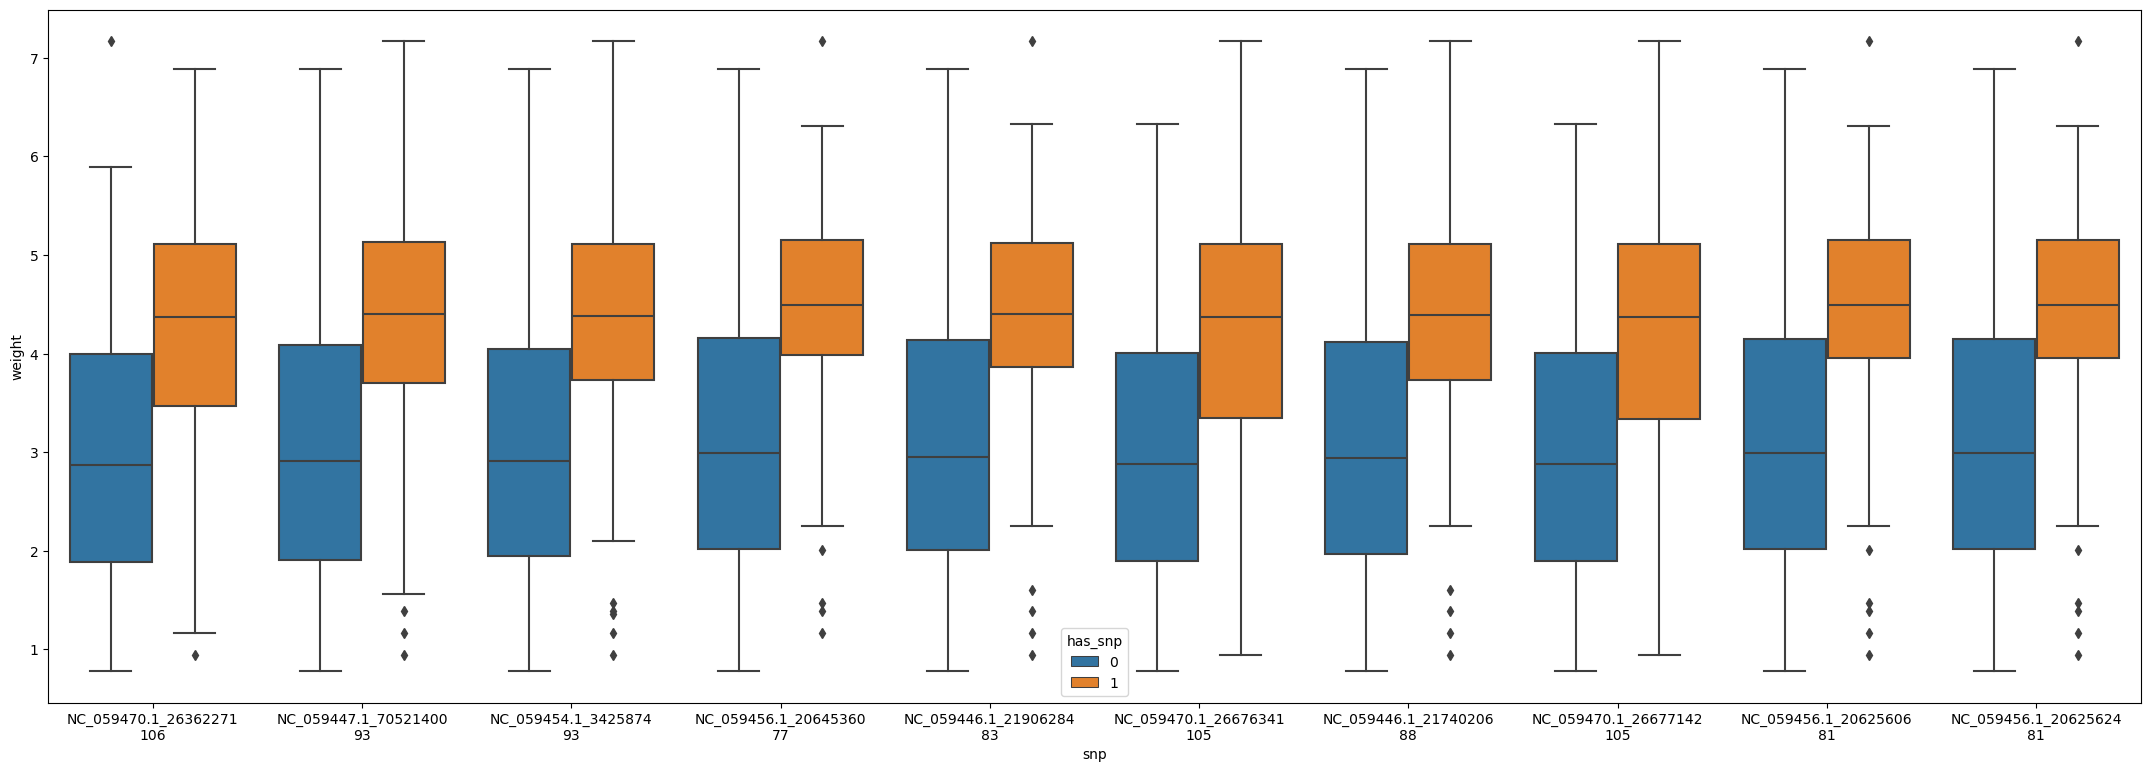

In [99]:
tenmost = mws.sort_values(by="maxscore", ascending=False).iloc[:10,:]
def meltything(row):
    foo = pd.DataFrame(gwasi.loc[row.Marker].T)
    foo[foo.columns[0]] = (foo[foo.columns[0]]>=0.5).astype(int)
    foo[["weight"]] = metadata.set_index("Sample.ID").loc[gwasi.T.index.values, ["Gutted.Weight.kg"] ]
    dt = foo.melt(id_vars="weight")
    dt.columns = ["weight","snp","has_snp"]
    return dt
lot = [meltything(r) for _,r in tenmost.iterrows()]

lot = pd.concat(lot).reset_index(drop=True)

lot["len1"] = lot.snp.map(dict(gwasib.loc[lot.snp.unique()].sum(axis=1)))

lot["snp"] = lot.snp +"\n" + lot.len1.apply(str)


plt.figure(figsize=(27,9))
#sns.boxplot(data=lot, x="snp", hue="has_snp" ,y="weight", palette=gray_scale(range(n_categories)))
sns.boxplot(data=lot, x="snp", hue="has_snp", y="weight")
plt.savefig("../../figures/GFGWA_boxplot.pdf")

In [100]:
marker_to_gene_d = dict(themap[["marker","GeneSymbol"]].values)
mws["gene"] = mws["Marker"].map(marker_to_gene_d)
gene_significance_sums = mws.groupby("gene").apply(lambda g: g.significant.sum())

In [101]:
gene_significance_sums.sort_values(ascending=False)

gene
LOC106610595    115
LOC106599468     95
arhgap17a        64
LOC106600871     54
LOC106603236     53
               ... 
LOC106582285      0
LOC106582284      0
LOC106582283      0
LOC106582281      0
zzef1             0
Length: 25234, dtype: int64

In [102]:
lot2 = []
for gene,g in relevant_mutations[relevant_mutations.marker.isin(gwasib_f.index.values)][["marker","GeneSymbol"]].groupby("GeneSymbol"):
    lot2.append( gwasib_f.loc[g.marker.values].sum(0) )

In [103]:
l2df = pd.DataFrame(lot2)

In [104]:
l2df

,F001,F002,F003,F004,F005,F006,F007,F008,F010,F011,...,F444,F445,F446,F447,F448,F449,F450,F451,F460,F461
0,0,1,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0
1,38,36,11,23,42,33,10,29,29,28,...,18,31,27,23,37,39,29,24,29,42
2,19,6,2,2,24,2,0,1,19,1,...,2,1,1,2,2,3,1,1,27,1
3,0,3,3,2,3,3,0,1,3,1,...,3,2,0,0,2,2,5,3,2,0
4,1,0,2,0,0,2,0,2,1,0,...,2,1,2,1,1,2,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24381,7,12,1,4,8,5,7,6,7,5,...,4,9,1,10,3,3,7,4,14,10
24382,13,12,9,11,13,8,7,11,8,11,...,10,9,12,12,8,12,8,14,8,13
24383,2,38,3,2,1,2,46,1,2,0,...,2,1,46,3,2,3,2,43,2,1
24384,23,25,16,9,17,23,19,15,15,22,...,11,20,19,22,22,15,14,25,16,17


In [105]:


l2df_standardized = (l2df.values - l2df.values.mean(axis=1, keepdims=True)) / l2df.values.std(axis=1, keepdims=True)

In [106]:
def meltything(row):
    foo = pd.DataFrame(gwasi.loc[row.Marker].T)
    foo[foo.columns[0]] = (foo[foo.columns[0]]>=0.5).astype(int)
    foo[["weight"]] = metadata.set_index("Sample.ID").loc[gwasi.T.index.values, ["Gutted.Weight.kg"] ]
    dt = foo.melt(id_vars="weight")
    dt.columns = ["weight","snp","has_snp"]
    return dt

In [107]:
tenmost = mws.sort_values(by="pval_AltGreater_log", ascending=False).iloc[:10,:]

In [108]:
tenleast = mws.sort_values(by="pval_AltLess_log", ascending=False).iloc[:10,:]

In [109]:
# tenmost

In [110]:
hundmost = mws.sort_values(by="pval_AltGreater_log", ascending=False).iloc[:100,:]

In [111]:
mws["score"] = mws[["pval_AltGreater_log","pval_AltLess_log"]].max(axis=1)

In [112]:
mws["minpval"] = mws[["pval_AltGreater","pval_AltLess"]].min(axis=1)

In [113]:
mws["gene"] = mws.Marker.map(dict(relevant_mutations[["marker","GeneSymbol"]].values))

/home/dylan/miniconda3/envs/gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

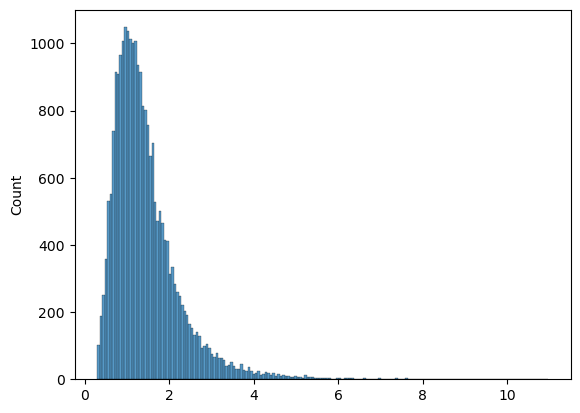

In [114]:
sns.histplot( mws.groupby("gene").apply(lambda g: g.score.mean()) )

In [115]:
genescores = mws.groupby("gene").apply(lambda g: g.score.mean())
genes_minpval = mws.groupby("gene").apply(lambda g: g.minpval.min())

In [116]:
genes_minpval

gene
143b2     0.048587
2a5e      0.000469
4f2       0.012341
5nt1a     0.060738
5ntc      0.009990
            ...   
zpr1      0.000167
zranb2    0.000016
zswim7    0.000152
zswim8    0.011779
zzef1     0.000018
Length: 24381, dtype: float64

In [117]:
genes_minpval_df = pd.DataFrame(data=list(genes_minpval), index=list(genes_minpval.index), columns = ["minpval"])
genes_minpval_df

,minpval
143b2,0.048587
2a5e,0.000469
4f2,0.012341
5nt1a,0.060738
5ntc,0.009990
...,...
zpr1,0.000167
zranb2,0.000016
zswim7,0.000152
zswim8,0.011779


In [118]:
genes_minpval_df.to_csv("../../data/salmon_data/GFGWA_genes_minpval.csv")

In [119]:
len(genescores)

24381

In [120]:
genescores_df = pd.DataFrame(data=list(genescores), index=list(genescores.index), columns = ["log_mws_score"])
genescores_df

,log_mws_score
143b2,0.926427
2a5e,0.992902
4f2,0.858712
5nt1a,0.815886
5ntc,1.076626
...,...
zpr1,0.967567
zranb2,1.070830
zswim7,0.622780
zswim8,0.732304


In [121]:
genescores_df.to_csv("../../data/salmon_data/GFGWA_gene_results_aggregated.csv")

In [122]:
mws.to_csv("../../data/salmon_data/GFGWA_gene_results_all.csv")

In [123]:
mws["chrom"] = mws.Marker.apply(lambda x: "_".join( x.split("_")[:2] ))
mws["pos"] = mws.Marker.apply(lambda x:  x.split("_")[-1] )

In [124]:
mws = mws.sort_values(by=["chrom","pos"])

In [125]:
mws

,Marker,pval_AltGreater,pval_AltLess,pval_two_sided,var_count,pval_AltGreater_log,pval_AltLess_log,maxscore,logpvalue,significant,gene,score,minpval,chrom,pos
154919,NC_059442.1_100361714,0.002996,0.997017,0.005993,53,2.523415,0.001298,2.523415,2.222385,False,LOC106579580,2.523415,0.002996,NC_059442.1,100361714
906548,NC_059442.1_100361766,0.436449,0.563982,0.872899,110,0.360066,0.248735,0.360066,0.059036,False,LOC106579580,0.360066,0.436449,NC_059442.1,100361766
317977,NC_059442.1_100361818,0.002520,0.997491,0.005040,53,2.598612,0.001091,2.598612,2.297582,False,LOC106579580,2.598612,0.002520,NC_059442.1,100361818
937306,NC_059442.1_100361919,0.950641,0.049475,0.098949,99,0.021984,1.305617,1.305617,1.004587,False,LOC106579580,1.305617,0.049475,NC_059442.1,100361919
593532,NC_059442.1_100362014,0.002869,0.997144,0.005738,54,2.542288,0.001242,2.542288,2.241258,False,LOC106579580,2.542288,0.002869,NC_059442.1,100362014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619966,NW_025550964.1_89819,0.883401,0.116814,0.233627,251,0.053842,0.932506,0.932506,0.631476,False,anxa5b,0.932506,0.116814,NW_025550964.1,89819
1084452,NW_025550964.1_89847,0.329854,0.670636,0.659708,301,0.481678,0.173513,0.481678,0.180648,False,anxa5b,0.481678,0.329854,NW_025550964.1,89847
305417,NW_025550964.1_94451,0.372573,0.627812,0.745146,204,0.428789,0.202170,0.428789,0.127759,False,anxa5b,0.428789,0.372573,NW_025550964.1,94451
322855,NW_025550964.1_94537,0.164458,0.835852,0.328917,288,0.783944,0.077870,0.783944,0.482914,False,anxa5b,0.783944,0.164458,NW_025550964.1,94537


In [126]:
lot = []
cmax = 0
for gn,g in mws.groupby("chrom"):
    g.pos = g.pos.astype(int) - g.pos.astype(int).min() + 10000000 + cmax
    lot.append( g.sort_values(by="pos") )
    cmax = g.pos.max()
foo = pd.concat(lot)  

In [129]:
?plt.axhline

Signature: plt.axhline(y: 'float' = 0, xmin: 'float' = 0, xmax: 'float' = 1, **kwargs) -> 'Line2D'
Docstring:
Add a horizontal line across the Axes.

Parameters
----------
y : float, default: 0
    y position in data coordinates of the horizontal line.

xmin : float, default: 0
    Should be between 0 and 1, 0 being the far left of the plot, 1 the
    far right of the plot.

xmax : float, default: 1
    Should be between 0 and 1, 0 being the far left of the plot, 1 the
    far right of the plot.

Returns
-------
`~matplotlib.lines.Line2D`

Other Parameters
----------------
**kwargs
    Valid keyword arguments are `.Line2D` properties, except for
    'transform':

    Properties:
    agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
    alpha: scalar or None
    animated: bool
    antialiased or aa: bool
    clip_box: `~matplotlib.transforms.BboxBase` or None
    clip

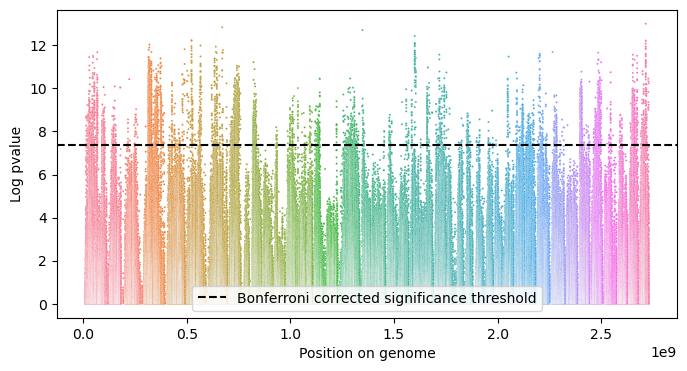

In [135]:
fig, ax = plt.subplots(figsize=(8,4))
sns.scatterplot(data = foo[foo.chrom.str.startswith("NC")],
               x = "pos",y="logpvalue", hue="chrom", 
                s=2,
               legend = False,
               ax=ax)
plt.xlabel("Position on genome")
plt.ylabel("Log pvalue")
plt.axhline(y=bonferroni_threshold, ls="--", color='k', label="Bonferroni corrected significance threshold")
plt.legend(loc="lower center")